<p style="text-align: center; font-size: 24px;"><b>Financial Sentiment Analysis Using Statistical and Neural NLP Approaches</b></p>
<p style="text-align: center; font-size: 18px;">Team #11 | John Pretz & Manas Sahoo | NLP | AI574 | Fall 2025 | Instructor: Prof. Bard</p>


## Project Overview

Financial texts—such as news articles, social media posts, and earnings calls—shape public perception and impact stock markets. Given the enormous volume of daily financial data, manual sentiment analysis is infeasible. Natural Language Processing (NLP) automates this process, extracting sentiment efficiently to provide actionable insights for investors.  

**Objective:** Compare statistical (TF-IDF + Logistic Regression) and neural (FinBERT) NLP approaches to evaluate their effectiveness in capturing financial sentiment.

**Key Features of the Project:**
- Sources: News, social media, and corporate reports.
- Statistical NLP: TF-IDF vectorization combined with Logistic Regression, including SMOTE for class imbalance.
- Neural NLP: FinBERT, a transformer-based financial sentiment model.
- Data Cleaning: Text preprocessing, label mapping, and exploratory data analysis.
- Evaluation Metrics: Accuracy, classification report, ROC-AUC, F1-score, confusion matrices.
- Visualizations: Word clouds, class distribution, prediction comparison, ROC curves, and F1-score charts.
- Insights: Misclassification analysis and sample predictions for real-world interpretability.


Dataset shape: (4845, 2)
Columns: Index(['neutral', 'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .'], dtype='object')
    neutral  \
0   neutral   
1  negative   
2  positive   
3  positive   
4  positive   

  According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .  
0  Technopolis plans to develop in stages an area...                                                                               
1  The international electronic industry company ...                                                                               
2  With the new production plant the company woul...                                                                               
3  According to the company 's updated strategy f...                                                                               
4  FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag

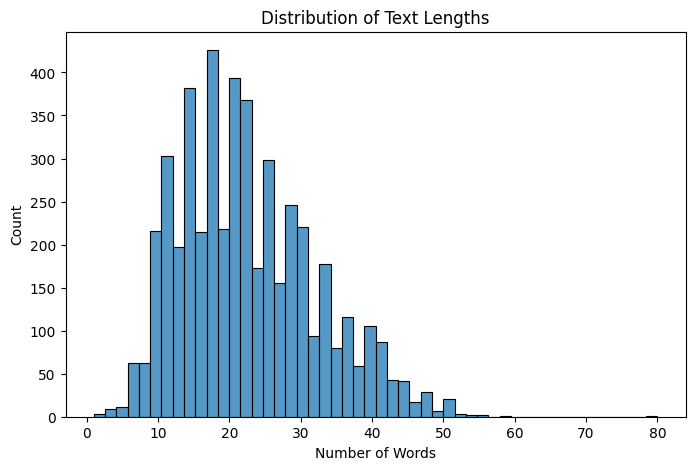

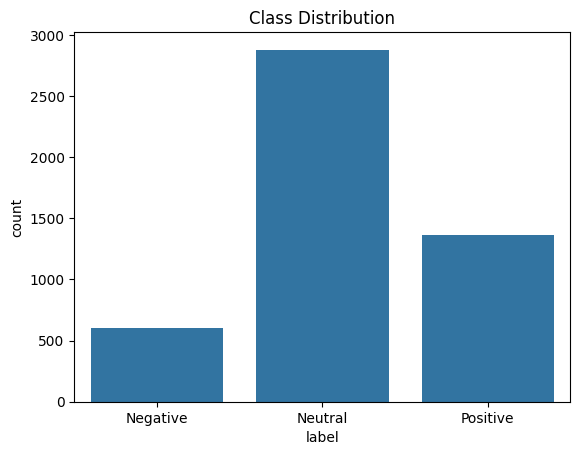

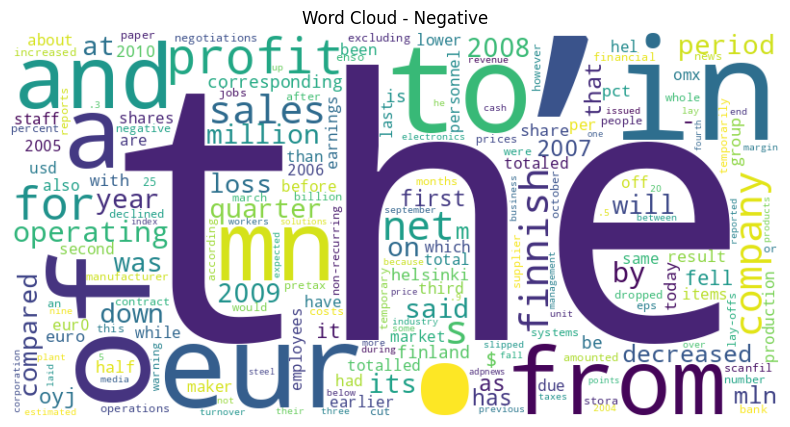

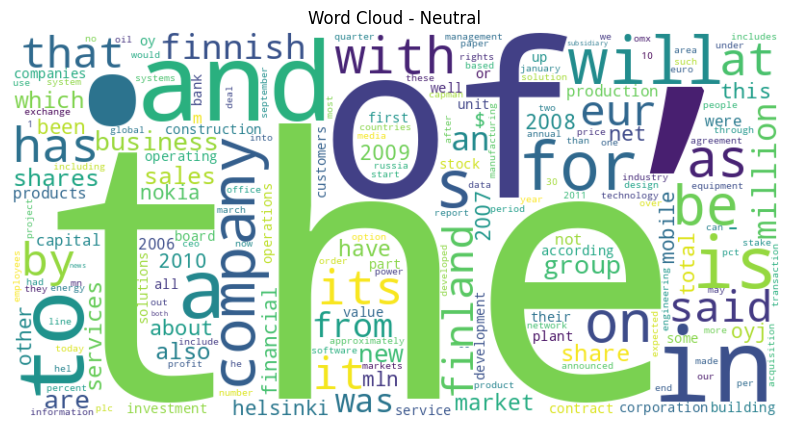

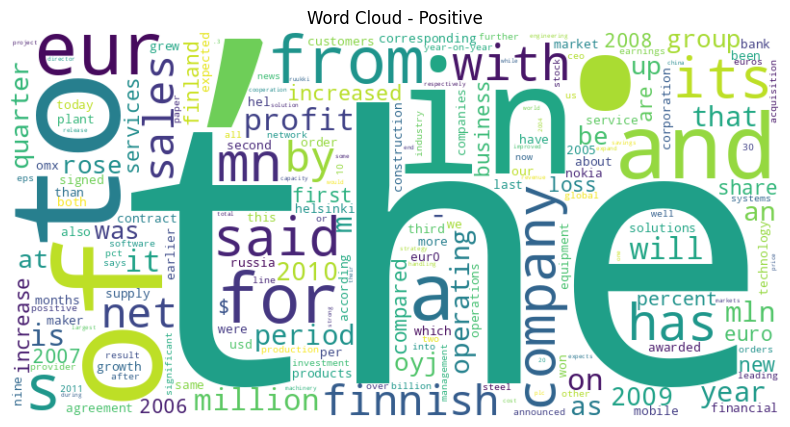

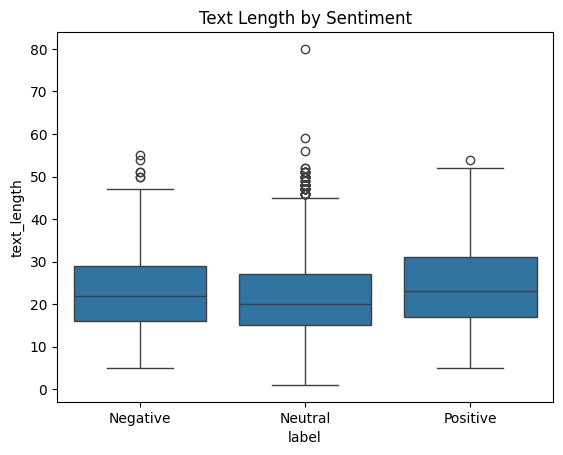

C:\Users\maste\anaconda3\envs\AI-574\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(



--- Logistic Regression Classification Report ---
              precision    recall  f1-score   support

    Negative     0.5789    0.6364    0.6063       121
     Neutral     0.7891    0.8576    0.8220       576
    Positive     0.6571    0.5074    0.5726       272

    accuracy                         0.7317       969
   macro avg     0.6751    0.6671    0.6670       969
weighted avg     0.7258    0.7317    0.7250       969

Accuracy: 0.7317
ROC-AUC: 0.8593


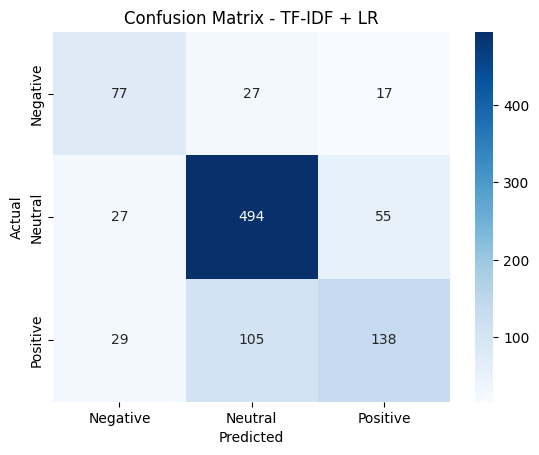

<Figure size 1000x600 with 0 Axes>

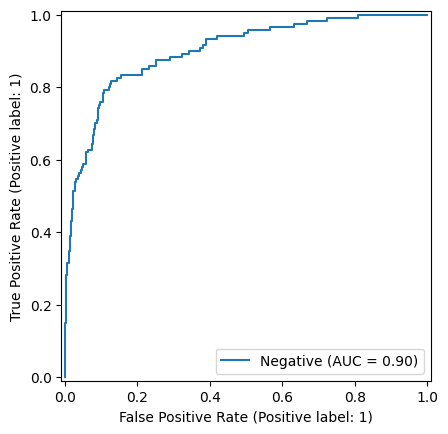

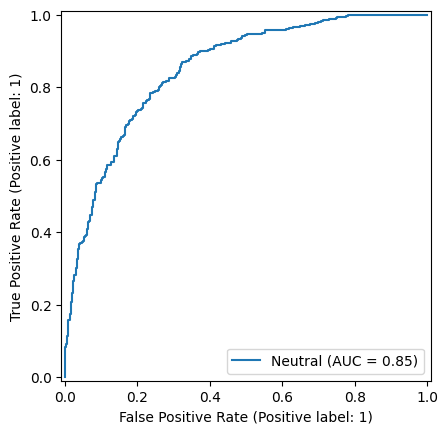

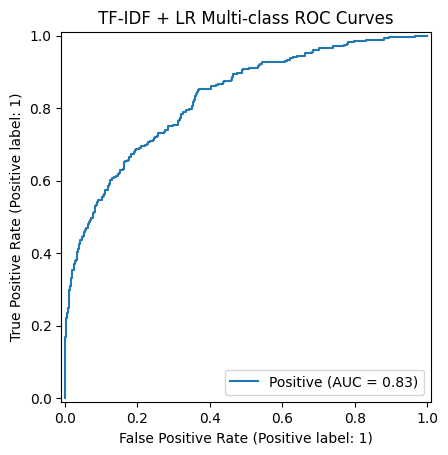

F1-score for Negative: 0.6063
F1-score for Neutral: 0.8220
F1-score for Positive: 0.5726

--- Sample Misclassified Examples ---
       neutral  \
1566  positive   
911   positive   
4754  negative   
4787  negative   
288   positive   
431    neutral   
4617   neutral   
863   positive   
3987  positive   
4029   neutral   

     According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .  \
1566  Nokia will continue to invest in future develo...                                                                                
911   This combined with foreign investments creates...                                                                                
4754  Operating profit totalled EUR 30.2 mn , down f...                                                                                
4787  According to the company , in addition to norm...                                                                          

Device set to use cpu



--- Sample Predictions (FinBERT) ---
The company reported record profits this quarter. --> Positive
Market volatility continues to concern investors. --> Negative
Revenue remained stable compared to last year. --> Neutral


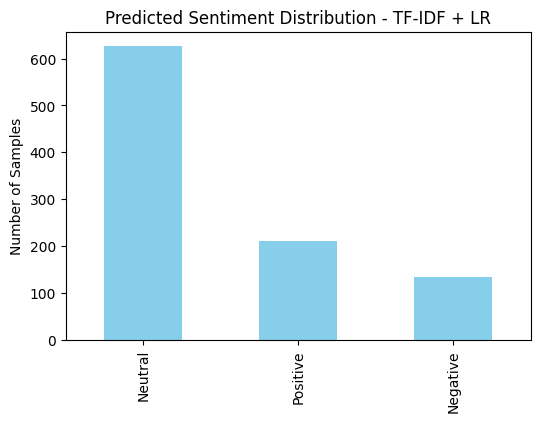

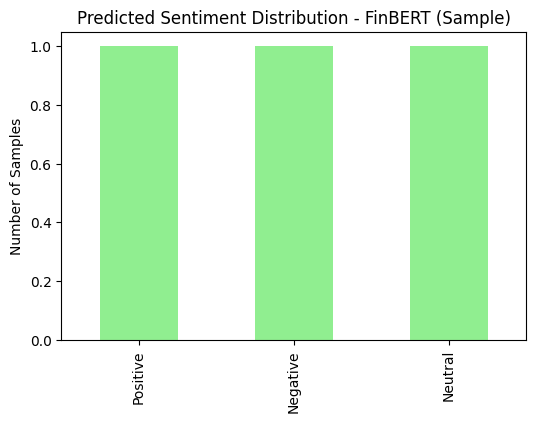

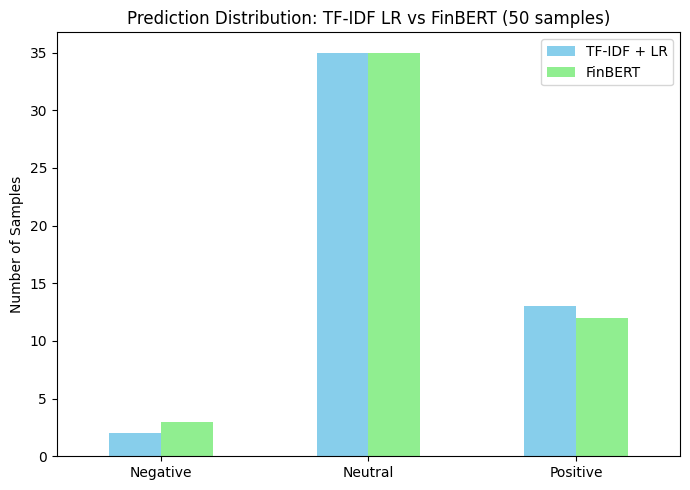

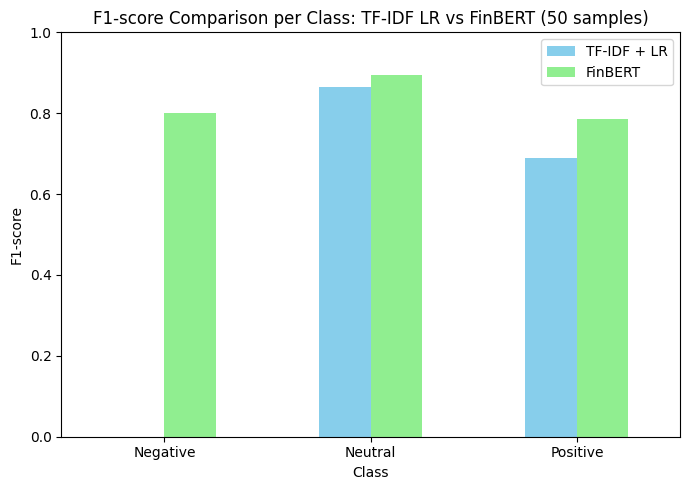

In [4]:
# ==============================
# 0. Imports
# ==============================
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, f1_score, RocCurveDisplay
from sklearn.preprocessing import label_binarize

from imblearn.over_sampling import SMOTE
from transformers import BertTokenizer, BertForSequenceClassification, pipeline

# ==============================
# 1. Load Dataset
# ==============================
data_path = r"C:\Users\maste\Container\AI_574\group project\all-data.csv"
df = pd.read_csv(data_path, encoding='ISO-8859-1')

print("Dataset shape:", df.shape)
print("Columns:", df.columns)
print(df.head())

# ==============================
# 2. Identify columns
# ==============================
sentiment_column = df.columns[0]
text_column = df.columns[1]
print(f"Sentiment column: {sentiment_column}, Text column: {text_column}")

# ==============================
# 3. Text cleaning
# ==============================
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'\S+@\S+', ' ', text)
    text = re.sub(r'[^a-z0-9\s\$\.\,\-\_]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['text_clean'] = df[text_column].fillna("").apply(clean_text)

# ==============================
# 4. Map sentiment labels
# ==============================
def map_sentiment(label):
    if str(label).lower() in ['negative', 'neg', '0']:
        return 0
    elif str(label).lower() in ['neutral', 'neu', '1']:
        return 1
    elif str(label).lower() in ['positive', 'pos', '2']:
        return 2
    else:
        return 1  # default to Neutral if unknown

df['label'] = df[sentiment_column].apply(map_sentiment)
print("Label distribution:\n", df['label'].value_counts())

# ==============================
# 5. EDA: Text length distribution
# ==============================
df['text_length'] = df['text_clean'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8,5))
sns.histplot(df['text_length'], bins=50)
plt.title("Distribution of Text Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Count")
plt.show()

# ==============================
# 6. EDA: Class distribution
# ==============================
sns.countplot(x='label', data=df)
plt.xticks([0,1,2], ["Negative","Neutral","Positive"])
plt.title("Class Distribution")
plt.show()

# ==============================
# 7. EDA: Word clouds per class
# ==============================
for label, name in zip([0,1,2], ["Negative","Neutral","Positive"]):
    words = ' '.join(df[df['label']==label]['text_clean']).split()
    word_freq = Counter(words)
    wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud - {name}")
    plt.show()

# ==============================
# 8. EDA: Text length vs sentiment
# ==============================
sns.boxplot(x='label', y='text_length', data=df)
plt.xticks([0,1,2], ["Negative","Neutral","Positive"])
plt.title("Text Length by Sentiment")
plt.show()

# ==============================
# 9. Split dataset
# ==============================
X_train, X_test, y_train, y_test = train_test_split(
    df['text_clean'], df['label'], test_size=0.2, stratify=df['label'], random_state=42
)

# ==============================
# 10. TF-IDF Vectorization
# ==============================
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=30000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# ==============================
# 11. SMOTE for imbalance
# ==============================
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_tfidf, y_train)

# ==============================
# 12. Train Logistic Regression
# ==============================
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')
lr_model.fit(X_train_res, y_train_res)

y_pred_lr = lr_model.predict(X_test_tfidf)
y_proba_lr = lr_model.predict_proba(X_test_tfidf)

print("\n--- Logistic Regression Classification Report ---")
print(classification_report(y_test, y_pred_lr, digits=4, target_names=["Negative","Neutral","Positive"]))
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy: {accuracy_lr:.4f}")
roc_auc_lr = roc_auc_score(label_binarize(y_test, classes=[0,1,2]), y_proba_lr, multi_class='ovr')
print(f"ROC-AUC: {roc_auc_lr:.4f}")

# ==============================
# 13. Confusion Matrix (LR)
# ==============================
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative","Neutral","Positive"], yticklabels=["Negative","Neutral","Positive"])
plt.title("Confusion Matrix - TF-IDF + LR")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# ==============================
# 14. ROC Curve (Multi-class LR)
# ==============================
y_test_bin = label_binarize(y_test, classes=[0,1,2])
plt.figure(figsize=(10,6))
for i, class_name in enumerate(["Negative","Neutral","Positive"]):
    RocCurveDisplay.from_predictions(y_test_bin[:,i], y_proba_lr[:,i], name=class_name)
plt.title("TF-IDF + LR Multi-class ROC Curves")
plt.show()

# ==============================
# 15. F1-score per class
# ==============================
f1_scores = f1_score(y_test, y_pred_lr, average=None)
for cls, f1 in zip(["Negative","Neutral","Positive"], f1_scores):
    print(f"F1-score for {cls}: {f1:.4f}")

# ==============================
# 16. Misclassification Analysis
# ==============================
misclassified = df.iloc[y_test.index][y_test != y_pred_lr]
print("\n--- Sample Misclassified Examples ---")
print(misclassified.head(10))

# ==============================
# 17. Sample Predictions (TF-IDF + LR)
# ==============================
sample_sentences = [
    "The company reported record profits this quarter.",
    "Market volatility continues to concern investors.",
    "Revenue remained stable compared to last year."
]

sample_clean = [clean_text(s) for s in sample_sentences]
sample_vec = vectorizer.transform(sample_clean)
sample_preds_lr = lr_model.predict(sample_vec)
print("\n--- Sample Predictions (TF-IDF + LR) ---")
for s, p in zip(sample_sentences, sample_preds_lr):
    label_str = {0:"Negative",1:"Neutral",2:"Positive"}[p]
    print(f"{s} --> {label_str}")

# ==============================
# 18. FinBERT Predictions (sample)
# ==============================
print("\nLoading FinBERT (may take a while)...")
finbert_model_name = "yiyanghkust/finbert-tone"
finbert_model = BertForSequenceClassification.from_pretrained(finbert_model_name, num_labels=3)
finbert_tokenizer = BertTokenizer.from_pretrained(finbert_model_name)
finbert_nlp = pipeline("sentiment-analysis", model=finbert_model, tokenizer=finbert_tokenizer)

sample_preds_finbert_raw = finbert_nlp(sample_sentences)
label_map = {"positive":2,"neutral":1,"negative":0}
sample_preds_finbert = [label_map[p['label'].lower()] for p in sample_preds_finbert_raw]

print("\n--- Sample Predictions (FinBERT) ---")
for s, p in zip(sample_sentences, sample_preds_finbert):
    label_str = {0:"Negative",1:"Neutral",2:"Positive"}[p]
    print(f"{s} --> {label_str}")

# ==============================
# 19. Prediction Distribution Visualization
# ==============================
# TF-IDF + LR
pred_counts_lr = pd.Series(y_pred_lr).map({0:"Negative",1:"Neutral",2:"Positive"}).value_counts()
pred_counts_lr.plot(kind='bar', color='skyblue', figsize=(6,4))
plt.title("Predicted Sentiment Distribution - TF-IDF + LR")
plt.ylabel("Number of Samples")
plt.show()

# FinBERT (sample)
pred_counts_finbert = pd.Series(sample_preds_finbert).map({0:"Negative",1:"Neutral",2:"Positive"}).value_counts()
pred_counts_finbert.plot(kind='bar', color='lightgreen', figsize=(6,4))
plt.title("Predicted Sentiment Distribution - FinBERT (Sample)")
plt.ylabel("Number of Samples")
plt.show()

# ==============================
# 20. Combined LR vs FinBERT Prediction Distribution (50 samples)
# ==============================
n_samples_plot = 50
X_plot = X_test[:n_samples_plot]
y_plot = y_test[:n_samples_plot]

# TF-IDF + LR
lr_labels_plot = pd.Series(lr_model.predict(vectorizer.transform(X_plot))).map({0:"Negative",1:"Neutral",2:"Positive"})

# FinBERT
finbert_preds_raw = finbert_nlp(X_plot.tolist())
y_pred_finbert_plot = np.array([label_map[p['label'].lower()] for p in finbert_preds_raw])
finbert_labels_plot = pd.Series(y_pred_finbert_plot).map({0:"Negative",1:"Neutral",2:"Positive"})

# Counts
lr_counts = lr_labels_plot.value_counts().reindex(["Negative","Neutral","Positive"], fill_value=0)
finbert_counts = finbert_labels_plot.value_counts().reindex(["Negative","Neutral","Positive"], fill_value=0)

comparison_df = pd.DataFrame({"TF-IDF + LR": lr_counts, "FinBERT": finbert_counts})

ax = comparison_df.plot(kind='bar', figsize=(7,5), color=['skyblue','lightgreen'])
plt.title("Prediction Distribution: TF-IDF LR vs FinBERT (50 samples)")
plt.ylabel("Number of Samples")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# ==============================
# 21. F1-score Comparison LR vs FinBERT (50 samples)
# ==============================
X_f1 = X_test[:50]
y_f1 = y_test[:50]

y_pred_lr_f1 = lr_model.predict(vectorizer.transform(X_f1))
finbert_preds_raw_f1 = finbert_nlp(X_f1.tolist())
y_pred_finbert_f1 = np.array([label_map[p['label'].lower()] for p in finbert_preds_raw_f1])

f1_classes = ["Negative","Neutral","Positive"]
f1_lr = f1_score(y_f1, y_pred_lr_f1, average=None)
f1_finbert = f1_score(y_f1, y_pred_finbert_f1, average=None)

f1_df = pd.DataFrame({"Class": f1_classes, "TF-IDF + LR": f1_lr, "FinBERT": f1_finbert}).set_index("Class")

ax = f1_df.plot(kind='bar', figsize=(7,5), color=['skyblue','lightgreen'])
plt.title("F1-score Comparison per Class: TF-IDF LR vs FinBERT (50 samples)")
plt.ylabel("F1-score")
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
